-------- Wyniki dla zbioru nr 0 --------
Accuracy: 0.8936127791330456
Sensitivity: 0.5358932461873638
Specificity: 0.936773828925924
Negative predictive value: 0.9435949373791934
Precision: 0.505601233299075
-------- Wyniki dla zbioru nr 1 --------
Accuracy: 0.9110996434603115
Sensitivity: 0.5743151446286096
Specificity: 0.940040458415499
Negative predictive value: 0.9625440405836287
Precision: 0.4514826106375129
-------- Wyniki dla zbioru nr 2 --------
Accuracy: 0.8961930005629574
Sensitivity: 0.5475060035563051
Specificity: 0.9378119304295314
Negative predictive value: 0.9455453953826978
Precision: 0.5123951345880011
-------- Wyniki dla zbioru nr 3 --------
Accuracy: 0.910321667604929
Sensitivity: 0.5739483199576683
Specificity: 0.9342814725473075
Negative predictive value: 0.9685396429152874
Precision: 0.38350782769254943
-------- Wyniki dla zbioru nr 4 --------
Accuracy: 0.90396298555076
Sensitivity: 0.5988463931836676
Specificity: 0.9310986330411535
Negative predictive value: 0.96

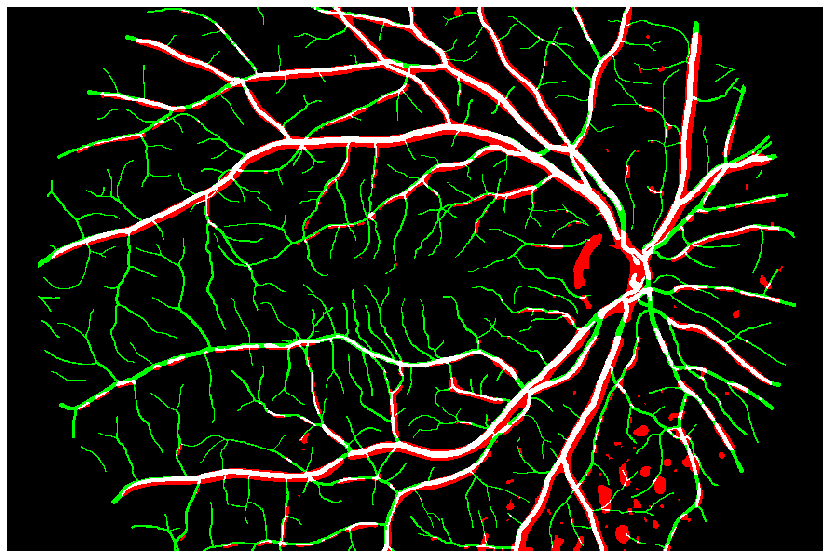

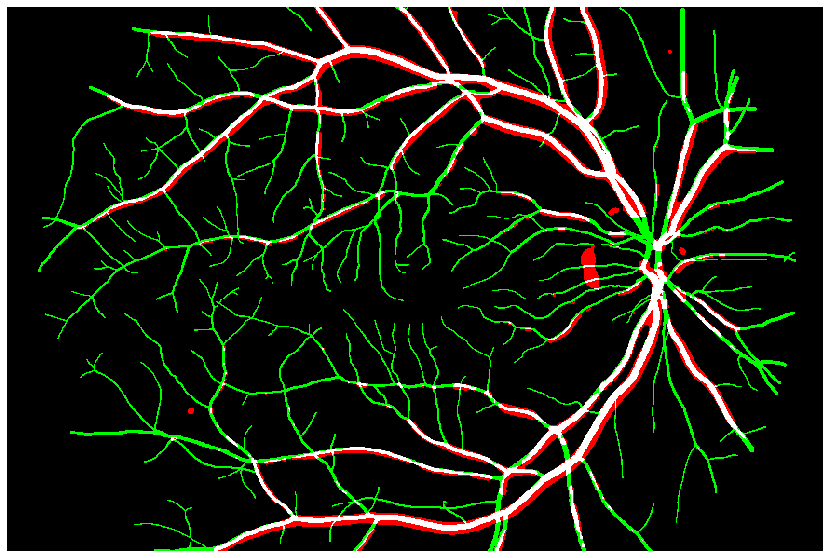

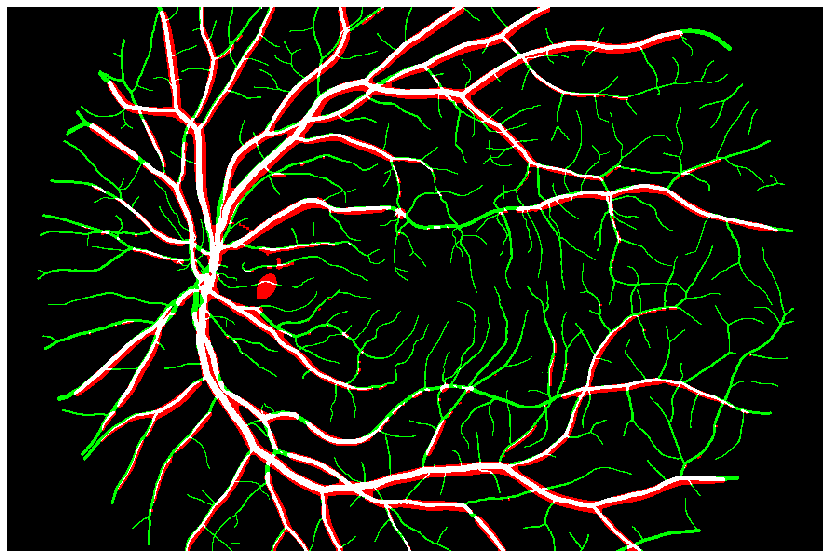

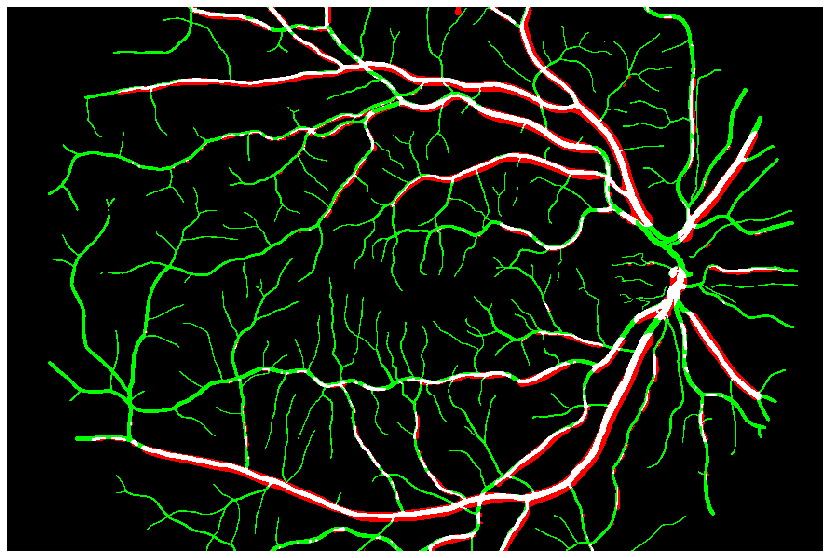

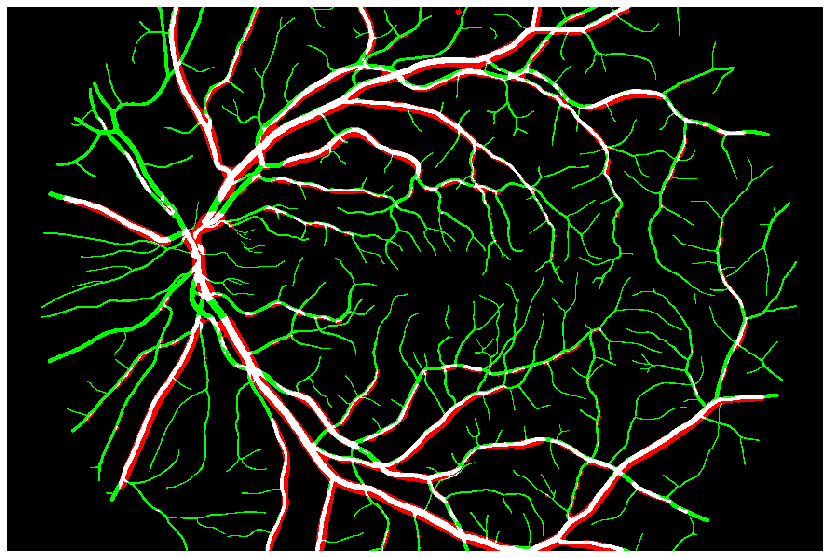

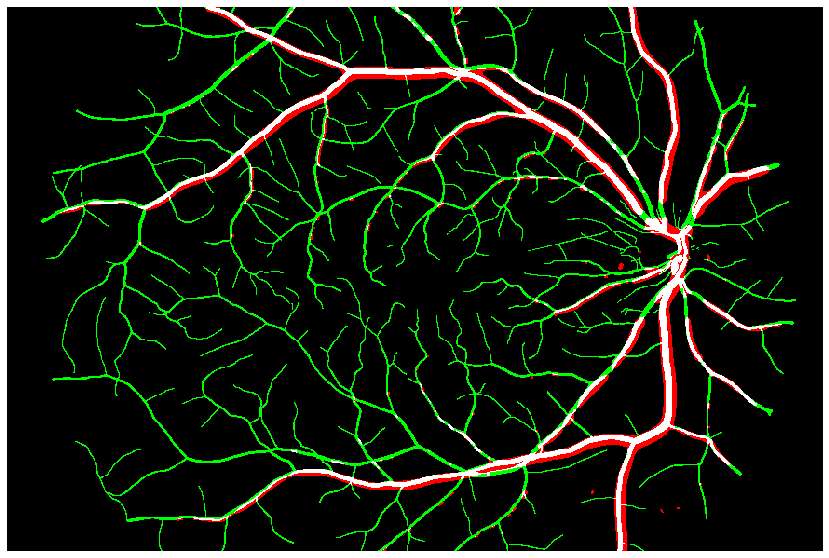

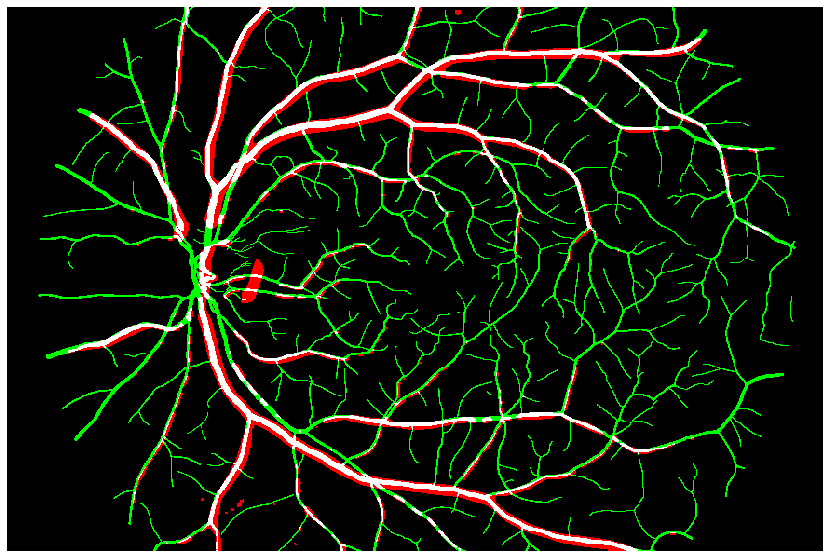

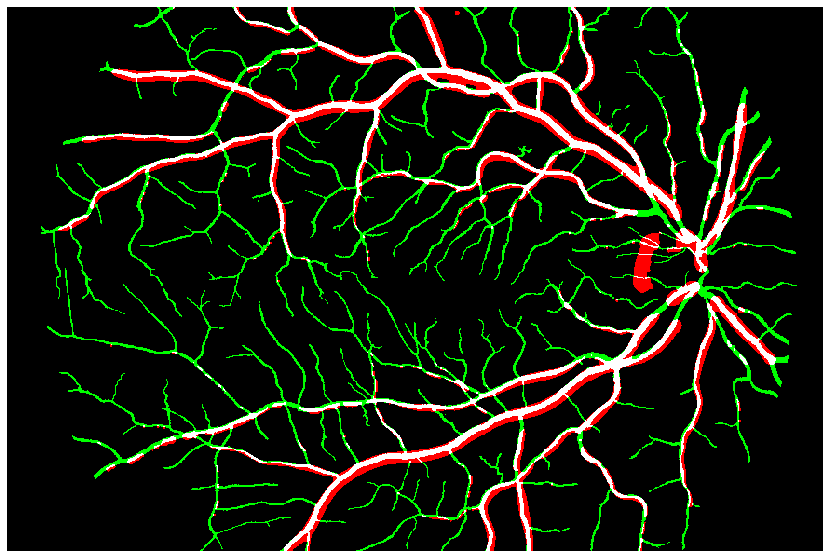

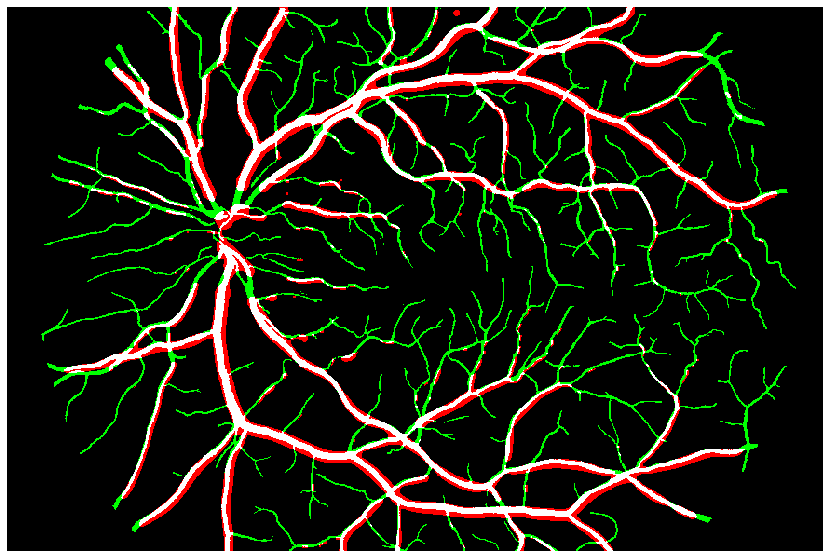

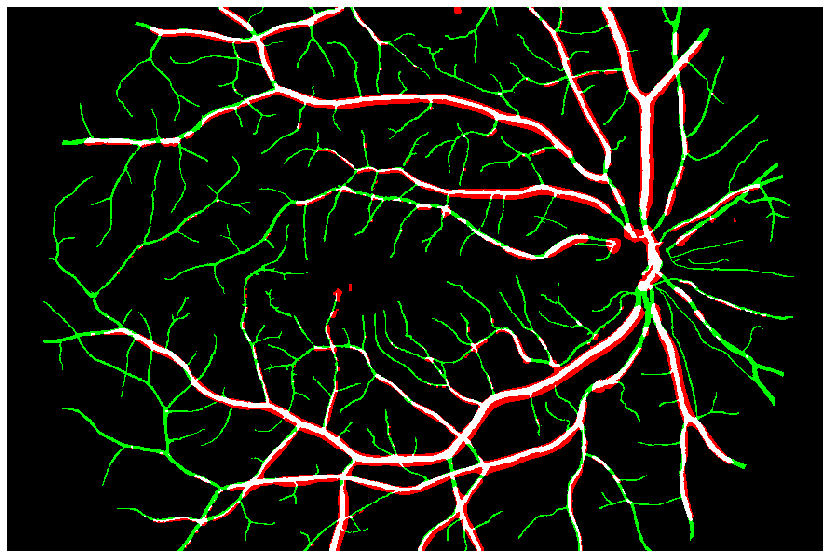

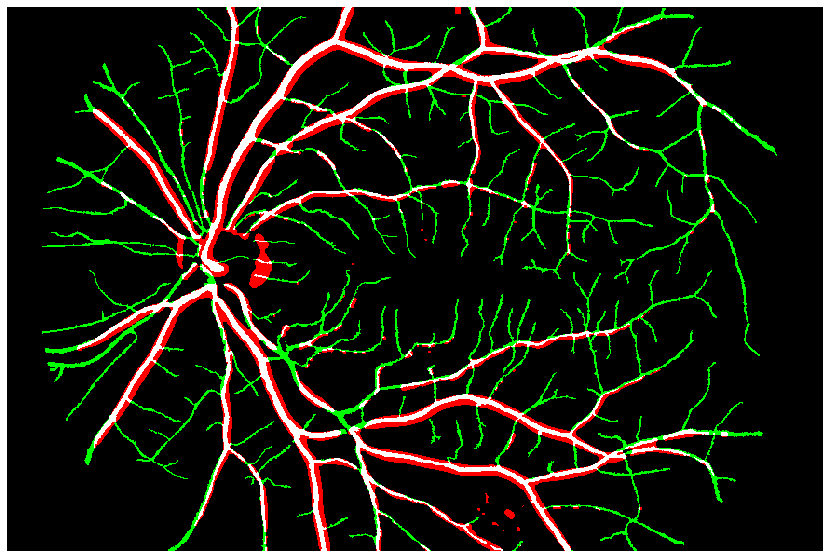

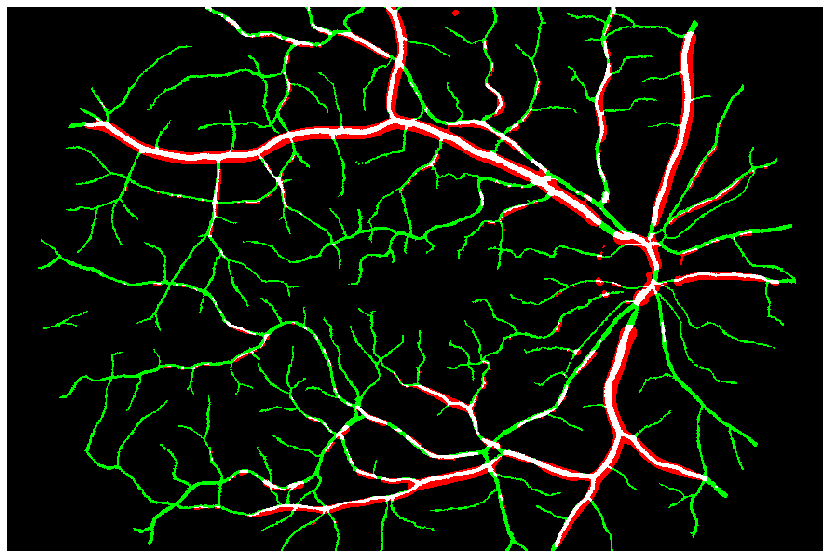

In [1]:
from matplotlib import pylab as plt
from skimage.filters import frangi
import numpy as np 
import cv2

def copy2dArrayFragment(array, x, y, r):
    res = []
    height, width = array.shape
    for i in range(height):
        for j in range(width):
            if j == x - r and i >= y-r and i <= y+r:
                res.append([])
            if j >= x - r and j <= x + r and i >= y - r and i <= y + r:
                res[i - (y - r)].append(array[i,j])
    return res

def removeEyeLens(detectFrom, output, max_circle_radius, eye_lens_offset):
    res = output.copy()
    detected_circles = cv2.HoughCircles(detectFrom,  
                                        cv2.HOUGH_GRADIENT, 1, 20, 
                                        param1 = 50, 
                                        param2 = 30,
                                        minRadius = 1, 
                                        maxRadius = max_circle_radius) 

    if detected_circles is not None: 
        detected_circles = np.uint16(np.around(detected_circles)) 
        
        pt = detected_circles[0][0]
        a, b, r = pt[0], pt[1], pt[2] 

        gray_values = []

        # wyznacz wartosc 10-tego percentyla, aby pozostawic ciemniejsze
        # miejsca (naczynia krwionosne)
        height, width = res.shape
        for i in range(height):
            for j in range(width):
                d = np.sqrt((j-a)**2 + (i-b)**2) - r
                if d < eye_lens_offset and d > 0:
                    gray_values.append(detectFrom[i, j])

        percentile_value = np.percentile(gray_values, 10)

        # odetnij z wynikowego obrazka wszystko, co znajduje sie w odleglosci
        # 20 poza kolem i jego szarosc nie miesci sie w percentylu
        for i in range(height):
            for j in range(width):
                d = np.sqrt((j-a)**2 + (i-b)**2) - r
                if d < 20 and d > 0 and detectFrom[i, j] > percentile_value:
                    res[i,j] = 255
        
    return res

ground_truth_paths = [
#                       'datasets/hrf/labeled/01_h.tif',
#                       'datasets/hrf/labeled/02_h.tif',
#                       'datasets/hrf/labeled/03_h.tif',
                      'datasets/hrf/labeled/04_h.tif',
                      'datasets/hrf/labeled/05_h.tif',
                      'datasets/hrf/labeled/06_h.tif',
                      'datasets/hrf/labeled/07_h.tif',
                      'datasets/hrf/labeled/08_h.tif',
                      'datasets/hrf/labeled/09_h.tif',
                      'datasets/hrf/labeled/10_h.tif',                      
                      'datasets/hrf/labeled/11_h.tif',
                      'datasets/hrf/labeled/12_h.tif',
                      'datasets/hrf/labeled/13_h.tif',
                      'datasets/hrf/labeled/14_h.tif',
                      'datasets/hrf/labeled/15_h.tif'
                     ]
img_paths = [
#              'datasets/hrf/01_h.jpg', 
#              'datasets/hrf/02_h.jpg',
#              'datasets/hrf/03_h.jpg',
             'datasets/hrf/04_h.jpg',
             'datasets/hrf/05_h.jpg',
             'datasets/hrf/06_h.jpg',
             'datasets/hrf/07_h.jpg',
             'datasets/hrf/08_h.jpg',
             'datasets/hrf/09_h.jpg',
             'datasets/hrf/10_h.jpg',             
             'datasets/hrf/11_h.jpg',
             'datasets/hrf/12_h.jpg',
             'datasets/hrf/13_h.jpg',
             'datasets/hrf/14_h.jpg',
             'datasets/hrf/15_h.jpg'
            ]

max_circle_radius = 50
eye_lens_offset = 40
resize_image_coeff = 0.25
avg_accuracy = avg_sensitivity = avg_specificity = avg_negative = avg_precision = 0

curr = 0

for curr in range(len(img_paths)):
    comparsion = []
    
    # wczytaj zdjecie ground truth
    img_ground = cv2.imread(ground_truth_paths[curr])
    img_ground = cv2.resize(img_ground, (0,0), fx=resize_image_coeff, fy=resize_image_coeff) 
    img_ground = cv2.cvtColor(img_ground, cv2.COLOR_BGR2GRAY)
    
    # odczytanie i wstepne przetworzenie zdjecia
    original = cv2.imread(img_paths[curr])
    resized = cv2.resize(original, (0,0), fx=resize_image_coeff, fy=resize_image_coeff) 
    img = gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    img = cv2.blur(gray, (3, 3))

    # threshold
    img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, 7)

    # usuniecie linii z soczewki oka
    img = removeEyeLens(gray, img, max_circle_radius, eye_lens_offset)

    # usun ramke
    height, width, depth = resized.shape
    for i in range(0, height):  
        for j in range(0, width): 
            if resized[i, j, 0] < 10 and resized[i, j, 1] < 10 and resized[i, j, 2] < 10:
                img[i,j] = 255
                
    # usun linie dookola ramki
    kernel = np.ones((2,2), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)

    # filtr frangi
    img=(frangi(img))

    # filtr morphology
    kernel = np.ones((4,4), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    height, width = img.shape
    for i in range(0, height):
        row_comparsion = []
        
        for j in range(0, width):
            
            isVessel = False
            if (img_ground[i,j] != 0.0):
                isVessel = True
            
            if img[i, j] > 0.00001:
                img[i,j] = 1.0
                if(isVessel == True):
                    row_comparsion.append(np.array([255, 255, 255]))
                else:
                    row_comparsion.append(np.array([255, 0, 0]))
            else:
                img[i, j] = 0.0
                if(isVessel != True):
                    row_comparsion.append(np.array([0, 0, 0]))
                else:
                    row_comparsion.append(np.array([0, 255, 0]))
        row_comparsion = np.array(row_comparsion)  
        comparsion.append(row_comparsion)

    plt.figure(figsize=(20,10))
    plt.subplot(1, 1, 1)
    plt.axis('off')
    plt.imshow(img, cmap="gray")
    plt.savefig("results/digital/digital-result-" + str(curr + 3) + '.png', bbox_inches='tight')
    
    comparsion = np.array(comparsion)
    
    plt.axis('off')
    plt.imshow(comparsion)
    plt.savefig("results/digital/digital-compare-" + str(curr + 3) + '.png', bbox_inches='tight')

    # sklasyfikuj sensitivity, specificity
    positive_all = 0
    negative_all = 0
    positive_true = 0
    negative_true = 0
    positive_false = 0
    negative_false = 0

    height, width = img_ground.shape

    for i in range(0, height):  
        for j in range(0, width): 
            if img_ground[i,j] == 0.0:
                negative_all += 1
                if img[i, j] == 0:
                    negative_true += 1
                else: 
                    negative_false += 1
            else: 
                positive_all += 1
                if img[i,j] == 1:
                    positive_true += 1
                else: 
                    positive_false += 1

    acc = (positive_true + negative_true)/(positive_all + negative_all)
    
    sen = positive_true / (positive_true + negative_false)
    spec = negative_true / (negative_true + positive_false)
    
    neg = negative_true / (negative_true + negative_false)
    prec = positive_true / (positive_true + positive_false)
    
    avg_accuracy += acc
    avg_sensitivity += sen
    avg_specificity += spec
    avg_negative += neg
    avg_precision += prec
    
    print("--------" + " Wyniki dla zbioru nr " + str(curr) + " --------")
    print("Accuracy: " + str(acc))

    print("Sensitivity: " + str(sen))
    print("Specificity: " + str(spec))

    print("Negative predictive value: " + str(neg))    
    print("Precision: " + str(prec))
    
curr += 1

print("Średnie wyniki dla tego rozwiązania")
print("średnie accuracy: " + str(avg_accuracy/curr))
print("średnie sensitivity: " + str(avg_sensitivity/curr))
print("średnie specificity: " + str(avg_specificity/curr))
print("średnie negative predictive value: " + str(avg_negative/curr))
print("średnie precision: " + str(avg_precision/curr))